<a href="https://colab.research.google.com/github/sakshamkumar1/tensorflow-notebooks/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

In [1]:
!nvidia-smi

Sat Apr 22 10:30:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Downloading and becoming one with the data

In [3]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-04-22 10:30:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.3MB/s    in 8.1s    

2023-04-22 10:30:42 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 director

In [5]:
## Creating data loaders (preparing the data)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

In [7]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [8]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
print((224, 224) + (3,))
print(IMAGE_SHAPE + (3,))

(224, 224, 3)
(224, 224, 3)


In [20]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [21]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [23]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
# Let's  fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent, 
                                  validation_data=test_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", 
                                                                         "resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230422-113344
Epoch 1/5
24/24 [==============================] - 19s 783ms/step - loss: 0.3239 - accuracy: 0.9267 - val_loss: 0.6887 - val_accuracy: 0.7760
Epoch 2/5
24/24 [==============================] - 18s 774ms/step - loss: 0.2696 - accuracy: 0.9480 - val_loss: 0.6583 - val_accuracy: 0.7788
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.2319 - accuracy: 0.9627 - val_loss: 0.6563 - val_accuracy: 0.7796
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.1972 - accuracy: 0.9680 - val_loss: 0.6453 - val_accuracy: 0.7856
Epoch 5/5
24/24 [==============================] - 18s 780ms/step - loss: 0.1720 - accuracy: 0.9813 - val_loss: 0.6426 - val_accuracy: 0.7828


In [35]:
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = list(range(1, len(loss) + 1))

  plt.figure()
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend();

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

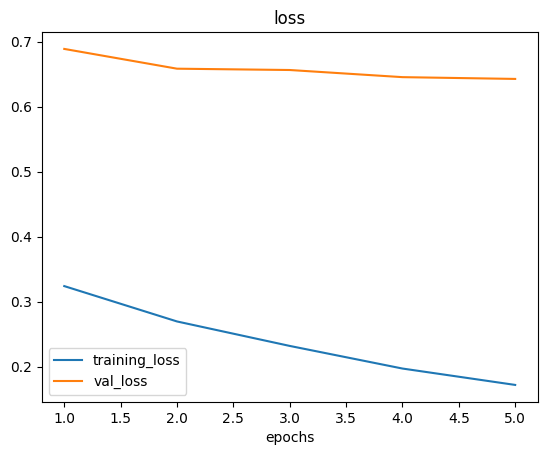

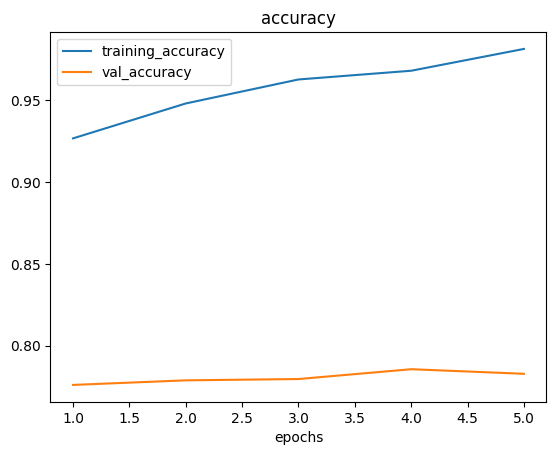

In [37]:
plot_loss_curve(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [38]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                                  train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [41]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback("tensorflow_hub", 
                                                                                      "efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230422-123548
Epoch 1/5
24/24 [==============================] - 23s 926ms/step - loss: 0.7547 - accuracy: 0.8387 - val_loss: 0.6964 - val_accuracy: 0.8452
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.6066 - accuracy: 0.8693 - val_loss: 0.6109 - val_accuracy: 0.8516
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.5114 - accuracy: 0.9000 - val_loss: 0.5568 - val_accuracy: 0.8648
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4443 - accuracy: 0.9093 - val_loss: 0.5243 - val_accuracy: 0.8644
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3895 - accuracy: 0.9253 - val_loss: 0.4919 - val_accuracy: 0.8720


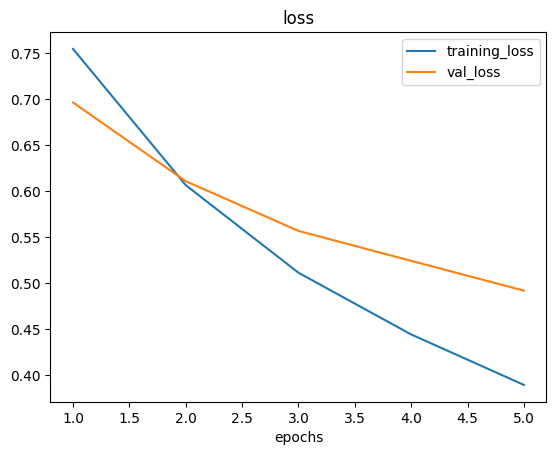

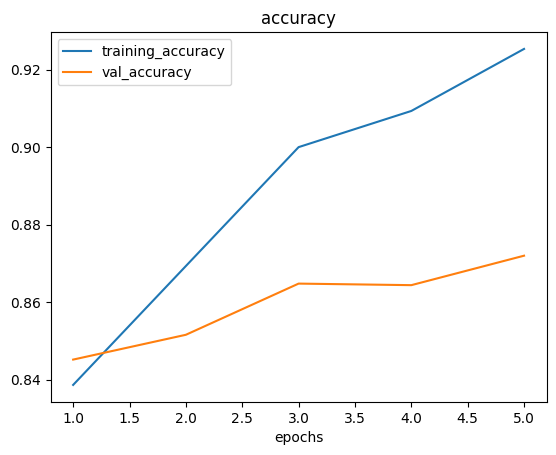

In [43]:
plot_loss_curve(efficientnet_history)